# Named Entity Recognition on Twitter

### Environment Setup: Libraries, Resources, and Dataset Initialization for Sequence Labeling with CRF and Transformers

We prepare the full runtime environment required for named entity recognition (NER) on social media text using both Conditional Random Fields (CRF) and transformer-based models.
It includes package verification and installation, NLP resource downloads, suppression of unnecessary warnings, and the import of all necessary modules for token-level classification.

Key components of this setup include:

- Automated Package Management: A utility function ensures that essential libraries such as numpy, pandas, sklearn, transformers, seqeval, and sklearn-crfsuite are installed before execution.

- NLTK Resource Management: Ensures required linguistic tools like the averaged perceptron tagger are available for POS-based feature extraction.

- Suppressing Non-critical Logs: Future warnings and verbose logs from the Hugging Face transformers library are silenced to maintain clean outputs.

- Core Libraries: Includes NumPy and pandas for numerical and tabular data handling.

- Visualization: Uses Matplotlib and Seaborn for performance plotting and error analysis.

- CRF Modeling Tools: Loads sklearn-crfsuite for training traditional sequence models with customizable features.

- Transformer-Based NER Framework: Loads pretrained token classification models and training utilities from Hugging Face Transformers, along with dynamic data collation and early stopping support.

- Evaluation Metrics: Imports entity-level evaluation functions from seqeval, including precision, recall, F1-score, and formatted reports in the BIO tagging scheme.

- Dataset Loading: Loads the Broad Twitter Corpus (BTC) using the Hugging Face datasets library for use in both CRF-based and transformer-based NER experiments.

We import all necessary packages, models, and utilities to support a complete token classification pipeline, from feature-rich CRFs to deep learning approaches, using real-world social media data.

In [1]:
# Automatically check and install required packages
import subprocess                                 
import sys                                        

# Install packages not present in the environment
def install_if_missing(packages):                
    for pip_name, import_name in packages.items():
        try:
            __import__(import_name)              
        except ImportError:
            print(f"Installing missing package: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

required_packages = {
    'numpy': 'numpy',                             
    'pandas': 'pandas',                          
    'matplotlib': 'matplotlib',                  
    'seaborn': 'seaborn',                        
    'nltk': 'nltk',                              
    'scikit-learn': 'sklearn',                  
    'sklearn-crfsuite': 'sklearn_crfsuite',      
    'torch': 'torch',                           
    'transformers': 'transformers',             
    'datasets': 'datasets',                       
    'seqeval': 'seqeval'                          
}

# Perform installation if any package is missing
install_if_missing(required_packages)           


# Download Required Resources 
# Ensures necessary corpora and models for NLP are available locally
import nltk                                       

try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')   
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')             


# Suppress Warnings and Logging
import warnings                                          # Manages warning messages
warnings.simplefilter("ignore", category=FutureWarning)  # Suppress specific warnings

from transformers import logging as hf_logging           # Controls logging behavior of Hugging Face transformers
hf_logging.set_verbosity_error()                         # Suppress all warning and info logs from transformers

# Core Libraries
import numpy as np                                   # Provides support for large, multi-dimensional arrays and matrices
import pandas as pd                                  # Offers data structures and operations for manipulating tabular data
from collections import defaultdict, Counter         # Provide dictionary subclasses that automatically initialize missing keys and count hashable objects

# Visualization Libraries
import matplotlib.pyplot as plt                      # Basic plotting library
from matplotlib.patches import Patch                 # Allows patch creation for plot legends
from matplotlib import colormaps                     # Provides access to color map schemes
import seaborn as sns                                # Enhances matplotlib with statistical visualization

# NLP and Token Classification Tools
import nltk                                          # Provides tools for natural language processing
nltk.download('averaged_perceptron_tagger_eng')      # Downloads English POS tagger for NLTK

# CRF Sequence Tagging
import sklearn_crfsuite                              # Implements Conditional Random Fields for sequence tagging
from sklearn_crfsuite import metrics                 # Provides evaluation metrics for CRF models

# Transformer-based Token Classification
import torch                                         # Core deep learning framework used by Hugging Face
from transformers import (                           # Pretrained transformer models and training utilities
    AutoTokenizer,                                   # Loads pretrained tokenizers
    AutoModelForTokenClassification,                 # Loads pretrained models for token classification
    TrainingArguments,                               # Configures training settings
    Trainer,                                         # High-level training interface
    DataCollatorForTokenClassification,              # Prepares batches with dynamic padding for token classification
    EarlyStoppingCallback                            # Stops training early based on validation performance
)

# Sequence Evaluation Metrics
from seqeval.metrics import (                        # Evaluation tools for sequence labeling (BIO format)
    precision_score,                                 # Computes precision per entity type
    recall_score,                                    # Computes recall per entity type
    f1_score,                                        # Computes F1 score for sequence labels
    classification_report                            # Generates a full classification report
)

# Load Hugging Face datasets
from datasets import load_dataset                      

# Load the BTC dataset from the TNER benchmark
btc_dataset = load_dataset("tner/btc")               
print(btc_dataset)

print("\nExample from training set:")
print(btc_dataset["train"][0])

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\karl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 6338
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1001
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 2000
    })
})

Example from training set:
{'tokens': ['I', 'hate', 'the', 'words', 'chunder', ',', 'vomit', 'and', 'puke', '.', 'BUUH', '.'], 'tags': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]}


### Task 1: Design Feature-Based and Neural Sequence Taggers for Twitter Named Entity Recognition

In this task, we design and evaluate multiple sequence tagging models for Named Entity Recognition on the Broad Twitter Corpus (BTC), comparing feature-based CRF approaches with a fine-tuned BERT-based neural sequence tagger.

Furthermore, we explore variations in feature design by incorporating part-of-speech information and Twitter-specific cues. We also address token-label alignment in subword-based models to support robust NER on informal text data.

#### Step 1: Feature-Based Sequence Tagging with CRF (Baseline Model: CRF-1)

In the first step, we implement a baseline Conditional Random Field (CRF) model using simple lexical features (e.g., word shape, casing, prefixes/suffixes) and contextual window features for Named Entity Recognition (NER) on the BTC dataset. We extract token-level features for each word in the sentence and train the CRF using L-BFGS optimization. The output includes a prediction–reference comparison on a real example from the test set in BIO tagging format.

In [2]:
# Define a feature extraction function for a single token in a sentence
def token2features_basic(sentence_tokens_basic, i_basic):
    # Extract the token at the current position
    token_basic = sentence_tokens_basic[i_basic]

    # Define basic lexical and orthographic features for the token
    features_basic = {
        'word.lower()': token_basic.lower(),
        'word.isupper()': token_basic.isupper(),
        'word.istitle()': token_basic.istitle(),
        'word.isdigit()': token_basic.isdigit(),
        'suffix[-3:]': token_basic[-3:],
        'prefix[:2]': token_basic[:2],
        'word.isalpha()': token_basic.isalpha(),
    }

    # Include contextual features from the previous token
    if i_basic > 0:
        token_prev_basic = sentence_tokens_basic[i_basic - 1]
        features_basic.update({
            'prev_word.lower()': token_prev_basic.lower(),
            'prev_word.isupper()': token_prev_basic.isupper(),
            'prev_word.istitle()': token_prev_basic.istitle(),
        })
    else:
        # Mark the beginning of a sentence
        features_basic['BOS'] = True

    # Include contextual features from the next token
    if i_basic < len(sentence_tokens_basic) - 1:
        token_next_basic = sentence_tokens_basic[i_basic + 1]
        features_basic.update({
            'next_word.lower()': token_next_basic.lower(),
            'next_word.isupper()': token_next_basic.isupper(),
            'next_word.istitle()': token_next_basic.istitle(),
        })
    else:
        # Mark the end of a sentence
        features_basic['EOS'] = True

    return features_basic

# Convert a full sentence into a list of token-level feature dictionaries
def sent2features_basic(sentence_dict_basic):
    sentence_tokens_basic = sentence_dict_basic['tokens']
    return [token2features_basic(sentence_tokens_basic, i_basic) 
            for i_basic in range(len(sentence_tokens_basic))]

# Map label IDs to string BIO labels using the dataset feature specification
tag_names_basic = btc_dataset["train"].features["tags"].feature.names

# Convert BTC dataset splits into train, validation, and test sets
train_sents_basic = list(btc_dataset["train"])
val_sents_basic = list(btc_dataset["validation"])
test_sents_basic = list(btc_dataset["test"])

# Convert a sentence dictionary to its corresponding list of label names
def sent2labels_basic(sentence_dict_basic):
    return [tag_names_basic[tag_id_basic] for tag_id_basic in sentence_dict_basic["tags"]]

# TRAIN THE CRF-1 MODEL
# Extract features and labels from the training and validation sets
X_train_basic = [sent2features_basic(s_basic) for s_basic in train_sents_basic]
y_train_basic = [sent2labels_basic(s_basic) for s_basic in train_sents_basic]

X_val_basic = [sent2features_basic(s_basic) for s_basic in val_sents_basic]
y_val_basic = [sent2labels_basic(s_basic) for s_basic in val_sents_basic]

# Initialize a CRF model using L-BFGS optimizer with regularization
crf_basic = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Fit the CRF model on the extracted training features and labels
crf_basic.fit(X_train_basic, y_train_basic)

# Print an example from the BTC test set to show the BIO tagging format
example_index_1 = 42
example_instance_1 = test_sents_basic[example_index_1]


# Extract tokens and ground truth tag
example_tokens_basic_1 = example_instance_1["tokens"]
reference_tags_basic_1 = sent2labels_basic(example_instance_1)

# Extract features and get CRF-1 prediction
features_basic_1 = sent2features_basic(example_instance_1)
predicted_tags_basic_1 = crf_basic.predict_single(features_basic_1)


# Create DataFrame
df_compare_crf1 = pd.DataFrame({
    "Token": example_tokens_basic_1,
    "Reference Label": reference_tags_basic_1,
    "CRF-1 Prediction": predicted_tags_basic_1
})

styled_df_compare_crf1 = (
    df_compare_crf1.style
    .hide(axis="index")
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]}
    ])
    .set_properties(**{"text-align": "left"})
)

# Display the output
print("CRF-1 Model Training Completed.\n")
print("CRF-1 Model Reference vs Predicted BIO Labels:\n")
display(styled_df_compare_crf1)

CRF-1 Model Training Completed.

CRF-1 Model Reference vs Predicted BIO Labels:



Token,Reference Label,CRF-1 Prediction
@,B-PER,B-PER
StephJWA,B-PER,B-PER
My,O,O
pleasure,O,O


#### Step 2: Feature-Enriched CRF with POS Tags (Baseline Model: CRF-2)

In this step, we enhance the CRF model by incorporating part-of-speech (POS) tags as additional features.
The improved model provides the model with syntactic cues that can help distinguish between named entities and common nouns. After that, we retrain the CRF and visualize predictions on a test sentence to evaluate improvement over the basic model.

In [3]:
# Define a feature extraction function that incorporates POS information
def token2features_pos(sentence_tokens_pos, i_pos, use_pos=True):
    # Extract the current token from the sentence
    token_pos = sentence_tokens_pos[i_pos]

    # Define basic lexical and structural features
    features_pos = {
        'word.lower()': token_pos.lower(),
        'word.isupper()': token_pos.isupper(),
        'word.istitle()': token_pos.istitle(),
        'word.isdigit()': token_pos.isdigit(),
        'suffix[-3:]': token_pos[-3:],
        'prefix[:2]': token_pos[:2],
        'word.isalpha()': token_pos.isalpha(),
    }

    # Include POS tag as an additional feature if enabled
    if use_pos:
        # Apply NLTK POS tagging to the full sentence (can be optimized)
        pos_tags_pos = nltk.pos_tag(sentence_tokens_pos)
        features_pos['pos'] = pos_tags_pos[i_pos][1]

    # Add contextual features from the previous token
    if i_pos > 0:
        token_prev_pos = sentence_tokens_pos[i_pos - 1]
        features_pos.update({
            'prev_word.lower()': token_prev_pos.lower(),
            'prev_word.isupper()': token_prev_pos.isupper(),
            'prev_word.istitle()': token_prev_pos.istitle(),
        })
    else:
        # Beginning of sentence indicator
        features_pos['BOS'] = True

    # Add contextual features from the next token
    if i_pos < len(sentence_tokens_pos) - 1:
        token_next_pos = sentence_tokens_pos[i_pos + 1]
        features_pos.update({
            'next_word.lower()': token_next_pos.lower(),
            'next_word.isupper()': token_next_pos.isupper(),
            'next_word.istitle()': token_next_pos.istitle(),
        })
    else:
        # End of sentence indicator
        features_pos['EOS'] = True

    return features_pos

# Convert a sentence into a sequence of feature dictionaries using the POS-aware extractor
def sent2features_pos(sentence_dict_pos, use_pos=True):
    sentence_tokens_pos = sentence_dict_pos['tokens']
    return [token2features_pos(sentence_tokens_pos, i_pos, use_pos=use_pos)
            for i_pos in range(len(sentence_tokens_pos))]

# Retrieve the label name list (BIO format) from the dataset metadata
tag_names_pos = btc_dataset["train"].features["tags"].feature.names

# Convert BTC dataset splits into train, validation, and test sets
train_sents_pos = list(btc_dataset["train"])
val_sents_pos = list(btc_dataset["validation"])
test_sents_pos = list(btc_dataset["test"])

# Convert tag IDs in a sentence to their corresponding string labels
def sent2labels_pos(sentence_dict_pos):
    return [tag_names_pos[tag_id_pos] for tag_id_pos in sentence_dict_pos["tags"]]

# TRAIN THE CRF-2 MODEL (with POS features)
# Extract feature representations and corresponding labels for training and validation sets
X_train_pos = [sent2features_pos(s_pos) for s_pos in train_sents_pos]
y_train_pos = [sent2labels_pos(s_pos) for s_pos in train_sents_pos]

X_val_pos = [sent2features_pos(s_pos) for s_pos in val_sents_pos]
y_val_pos = [sent2labels_pos(s_pos) for s_pos in val_sents_pos]

# Initialize a CRF model using L-BFGS optimizer and enable all possible transitions
crf_pos = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model on training data with token features + POS
crf_pos.fit(X_train_pos, y_train_pos)

# Print an example from the BTC test set to show the BIO tagging format
example_index_2 = 42
example_instance_2 = test_sents_pos[example_index_2]

# Extract tokens and ground truth tags
example_tokens_pos_2 = example_instance_2["tokens"]
example_tags_pos_2 = sent2labels_pos(example_instance_2)

# Extract features and get CRF-2 prediction
features_crf2 = sent2features_pos(example_instance_2)  
predicted_tags_pos_2 = crf_pos.predict_single(features_crf2)  

# Create DataFrame
df_compare_crf2 = pd.DataFrame({
    "Token": example_tokens_pos_2,
    "True Label": example_tags_pos_2,
    "CRF-2 Prediction": predicted_tags_pos_2
})

styled_df_compare_crf2 = (
    df_compare_crf2.style
    .hide(axis="index")
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]}
    ])
    .set_properties(**{"text-align": "left"})
)

# Display the output
print("CRF-2 Model Training Completed.\n")
print("CRF-2 Model Reference vs Predicted BIO Labels:\n")
display(styled_df_compare_crf2)

CRF-2 Model Training Completed.

CRF-2 Model Reference vs Predicted BIO Labels:



Token,True Label,CRF-2 Prediction
@,B-PER,B-PER
StephJWA,B-PER,B-PER
My,O,O
pleasure,O,O


#### Step 3: Twitter-Aware CRF with Social Media Features (Baseline Model: CRF-3)

In this step, we further improve the CRF model by including Twitter-specific features such as user mentions (@), hashtags (#), and URL detection. These features are incorporated into the structure of social media text and aim to improve entity recognition performance in noisy user-generated content. Subsequently, we compare predictions against gold-standard BIO labels.

In [4]:
# Define a feature extraction function that incorporates POS information and Twitter variant
def token2features_tw(sentence_tokens_tw, i_tw, use_pos=True):

    # Extract current token
    token_tw = sentence_tokens_tw[i_tw]

    # Define basic lexical and structural features for the token
    features_tw = {
        'word.lower()': token_tw.lower(),
        'word.isupper()': token_tw.isupper(),
        'word.istitle()': token_tw.istitle(),
        'word.isdigit()': token_tw.isdigit(),
        'suffix[-3:]': token_tw[-3:],
        'prefix[:2]': token_tw[:2],
        'word.isalpha()': token_tw.isalpha(),
    }

    # Include POS tag as a feature if enabled
    if use_pos:
        # Tag the full sentence and extract POS tag of current token
        pos_tags_tw = nltk.pos_tag(sentence_tokens_tw)
        features_tw['pos'] = pos_tags_tw[i_tw][1]

    # Add Twitter-specific binary indicators
    features_tw['has_at'] = ('@' in token_tw)        # '@' often indicates user mention
    features_tw['has_hash'] = ('#' in token_tw)      # '#' often indicates hashtags
    features_tw['is_url'] = (token_tw.startswith('http') or token_tw.startswith('www'))  # detect links

    # Add contextual features from the previous token
    if i_tw > 0:
        token_prev_tw = sentence_tokens_tw[i_tw - 1]
        features_tw.update({
            'prev_word.lower()': token_prev_tw.lower(),
            'prev_word.isupper()': token_prev_tw.isupper(),
            'prev_word.istitle()': token_prev_tw.istitle(),
        })
    else:
        # Mark the beginning of the sentence
        features_tw['BOS'] = True

    # Add contextual features from the next token
    if i_tw < len(sentence_tokens_tw) - 1:
        token_next_tw = sentence_tokens_tw[i_tw + 1]
        features_tw.update({
            'next_word.lower()': token_next_tw.lower(),
            'next_word.isupper()': token_next_tw.isupper(),
            'next_word.istitle()': token_next_tw.istitle(),
        })
    else:
        # Mark the end of the sentence
        features_tw['EOS'] = True

    return features_tw

# Convert an entire sentence into token-level feature dictionaries
def sent2features_tw(sentence_dict_tw, use_pos=True):
    sentence_tokens_tw = sentence_dict_tw['tokens']
    return [token2features_tw(sentence_tokens_tw, i_tw, use_pos=use_pos)
            for i_tw in range(len(sentence_tokens_tw))]

# Retrieve list of BIO tag labels from the dataset metadata
tag_names_tw = btc_dataset["train"].features["tags"].feature.names

# Convert BTC dataset splits into train, validation, and test sets
train_sents_tw = list(btc_dataset["train"])
val_sents_tw = list(btc_dataset["validation"])
test_sents_tw = list(btc_dataset["test"])

# Convert tag IDs to label names for a given sentence
def sent2labels_tw(sentence_dict_tw):
    return [tag_names_tw[tag_id_tw] for tag_id_tw in sentence_dict_tw["tags"]]

# TRAIN THE CRF-3 MODEL (POS + Twitter)
# Generate training and validation feature representations and labels
X_train_tw = [sent2features_tw(s_tw) for s_tw in train_sents_tw]
y_train_tw = [sent2labels_tw(s_tw) for s_tw in train_sents_tw]

X_val_tw = [sent2features_tw(s_tw) for s_tw in val_sents_tw]
y_val_tw = [sent2labels_tw(s_tw) for s_tw in val_sents_tw]

# Initialize a CRF model using L-BFGS optimizer and include transition generalization
crf_tw = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model using training feature-label sequences
crf_tw.fit(X_train_tw, y_train_tw)

# Print an example from the BTC test set to show the BIO tagging format
example_index_3 = 42
example_instance_3 = test_sents_tw[example_index_3]

# Extract tokens and ground truth tags
example_tokens_tw_3 = example_instance_3["tokens"]
example_tags_tw_3 = sent2labels_tw(example_instance_3)

# Extract features and get CRF-3 prediction
features_crf3 = sent2features_tw(example_instance_3)
predicted_tags_tw_3 = crf_tw.predict_single(features_crf3)

# Create DataFrame
df_compare_crf3 = pd.DataFrame({
    "Token": example_tokens_tw_3,
    "Reference Label": example_tags_tw_3,
    "CRF-3 Prediction": predicted_tags_tw_3
})

styled_df_compare_crf3 = (
    df_compare_crf3.style
    .hide(axis="index")
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]}
    ])
    .set_properties(**{"text-align": "left"})
)

# Display the output
print("CRF-3 Model Training Completed.\n")
print("CRF-3 Model Reference vs Predicted BIO Labels:\n")
display(styled_df_compare_crf3)

CRF-3 Model Training Completed.

CRF-3 Model Reference vs Predicted BIO Labels:



Token,Reference Label,CRF-3 Prediction
@,B-PER,B-PER
StephJWA,B-PER,B-PER
My,O,O
pleasure,O,O


#### Step 4: Neural Sequence Tagging with Token-Level BERT (Baseline Model: BERT)

In this step, we implement a transformer-based neural sequence tagger using a pretrained BERT model (bert-base-cased) fine-tuned for token classification on the BTC dataset. We handle subword tokenization by aligning word-level BIO tags to subword units using the tokenizer’s word_ids() mapping. The model is trained using the Hugging Face Trainer API with early stopping based on validation F1.

In [5]:
# Load the BTC dataset
btc_dataset_bert = load_dataset("tner/btc")

# Extract train, validation, and test subsets
train_data_bert = btc_dataset_bert["train"]
val_data_bert = btc_dataset_bert["validation"]
test_data_bert = btc_dataset_bert["test"]

# Retrieve the list of label names (e.g., "O", "B-PER", "I-LOC", etc.)
label_names_bert = btc_dataset["train"].features["tags"].feature.names

# Create mappings between label names and numeric IDs
label2id_bert = {label: i for i, label in enumerate(label_names_bert)}
id2label_bert = {i: label for label, i in label2id_bert.items()}

# Load the tokenizer corresponding to the pretrained BERT model
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased")

# Define a function to tokenize text and align word-level BIO labels to subword tokens
def tokenize_and_align_bert(example, label_all_tokens=True):
    tokenized_inputs = tokenizer_bert(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=False,
        padding=False
    )
    # Map each subword token back to the original word index
    word_ids = tokenized_inputs.word_ids()
    labels = example["tags"]
    aligned_labels = []
    previous_word_idx = None

    # Assign labels to subword tokens, respecting word boundaries
    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100) 
        elif word_idx != previous_word_idx:
            aligned_labels.append(labels[word_idx])  
        else:
            aligned_labels.append(labels[word_idx] if label_all_tokens else -100)  
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# Apply tokenization and label alignment to each dataset split
train_bert = train_data_bert.map(tokenize_and_align_bert, batched=False)
val_bert = val_data_bert.map(tokenize_and_align_bert, batched=False)
test_bert = test_data_bert.map(tokenize_and_align_bert, batched=False)

# Create a data collator that handles dynamic padding of inputs and labels
data_collator_bert = DataCollatorForTokenClassification(tokenizer=tokenizer_bert)

# Load the pretrained BERT model and configure it for token-level classification
model_bert = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label_names_bert),
    id2label=id2label_bert,
    label2id=label2id_bert
)

# Custom compute_metrics with seqeval
# Define evaluation metric computation using the seqeval library
def compute_metrics(p):
    predictions, label_ids = p
    predictions = predictions.argmax(axis=2)

    true_labels = []
    true_preds = []

    # For each sequence, exclude ignored labels (-100) and convert predictions to label names
    for pred_seq, label_seq in zip(predictions, label_ids):
        filtered_labels = []
        filtered_preds = []
        for p_i, l_i in zip(pred_seq, label_seq):
            if l_i != -100:
                filtered_labels.append(label_names_bert[l_i])
                filtered_preds.append(label_names_bert[p_i])
        true_labels.append(filtered_labels)
        true_preds.append(filtered_preds)

    # Compute precision, recall, and F1 using seqeval
    prec = precision_score(true_labels, true_preds)
    rec = recall_score(true_labels, true_preds)
    f1 = f1_score(true_labels, true_preds)
    return {
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

# Define training hyperparameters
training_args_bert = TrainingArguments(
    output_dir="bert-ner-btc",                        
    overwrite_output_dir=True,                        
    eval_strategy="epoch",                             
    save_strategy="epoch",                          
    save_total_limit=1,                              
    load_best_model_at_end=True,                  
    metric_for_best_model="f1",                       
    greater_is_better=True,                          
    num_train_epochs=5,                              
    per_device_train_batch_size=32,                   
    per_device_eval_batch_size=32,                   
    logging_dir="logs",                                
    logging_steps=100,                               
    learning_rate=5e-5,                              
    fp16=True,                                          
    disable_tqdm=False,                               
    weight_decay=0.01                                 
)

# Initialize the Trainer with model, data, and training config
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    tokenizer=tokenizer_bert,
    data_collator=data_collator_bert,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    compute_metrics=compute_metrics  
)

# TRAIN THE BERT MODEL
trainer_bert.train()

# Convert BTC dataset splits into train, validation, and test sets
train_sents_bert = list(btc_dataset["train"])
val_sents_bert = list(btc_dataset["validation"])
test_sents_bert = list(btc_dataset["test"])

# Print an example from the BTC test set to show the BIO tagging format
example_index_bert = 42
example_instance_bert = test_sents_bert[example_index_bert]

# Extract tokens and ground truth tags
example_tokens_bert = example_instance_bert["tokens"]
reference_tags_bert = [label_names_bert[tag_id] for tag_id in example_instance_bert["tags"]]

# Tokenize and predict with fine-tuned model
inputs = tokenizer_bert(example_tokens_bert, is_split_into_words=True, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model_bert(**inputs)

# Get prediction
pred_ids = outputs.logits.argmax(dim=-1).squeeze().tolist()
word_ids = inputs.word_ids()

# Align prediction with words
predicted_tags_bert = []
previous_word_idx = None
for idx, word_idx in enumerate(word_ids):
    if word_idx is None or word_idx == previous_word_idx:
        continue
    predicted_tag = label_names_bert[pred_ids[idx]]
    predicted_tags_bert.append(predicted_tag)
    previous_word_idx = word_idx

# Create DataFrame
df_compare_bert = pd.DataFrame({
    "Token": example_tokens_bert,
    "Reference Label": reference_tags_bert,
    "BERT Prediction": predicted_tags_bert
})

styled_df_compare_bert = (
    df_compare_bert.style
    .hide(axis="index")
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]}
    ])
    .set_properties(**{"text-align": "left"})
)

# Display the output
print("Early stopping triggered: Validation F1 score did not improve for 2 consecutive epochs.\n")
print("BERT Model Training Completed.\n")
print("BERT Model Reference vs Predicted BIO Labels:\n")
display(styled_df_compare_bert)

Map:   0%|          | 0/6338 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

  0%|          | 0/995 [00:00<?, ?it/s]

{'loss': 0.3027, 'grad_norm': 1.516888976097107, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.5}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2706620693206787, 'eval_precision': 0.6676783004552352, 'eval_recall': 0.7379454926624738, 'eval_f1': 0.7010555666201952, 'eval_runtime': 36.0452, 'eval_samples_per_second': 27.771, 'eval_steps_per_second': 0.888, 'epoch': 1.0}
{'loss': 0.1869, 'grad_norm': 1.0351930856704712, 'learning_rate': 3.9949748743718597e-05, 'epoch': 1.01}
{'loss': 0.1198, 'grad_norm': 1.9913878440856934, 'learning_rate': 3.4924623115577894e-05, 'epoch': 1.51}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2805761694908142, 'eval_precision': 0.6645678305666858, 'eval_recall': 0.730188679245283, 'eval_f1': 0.6958345819598442, 'eval_runtime': 36.3122, 'eval_samples_per_second': 27.567, 'eval_steps_per_second': 0.881, 'epoch': 2.0}
{'loss': 0.1142, 'grad_norm': 1.232444405555725, 'learning_rate': 2.989949748743719e-05, 'epoch': 2.01}
{'loss': 0.0715, 'grad_norm': 1.064980149269104, 'learning_rate': 2.4874371859296484e-05, 'epoch': 2.51}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.31998205184936523, 'eval_precision': 0.703026344437187, 'eval_recall': 0.6769392033542977, 'eval_f1': 0.689736195663783, 'eval_runtime': 33.7217, 'eval_samples_per_second': 29.684, 'eval_steps_per_second': 0.949, 'epoch': 3.0}
{'train_runtime': 2215.0144, 'train_samples_per_second': 14.307, 'train_steps_per_second': 0.449, 'train_loss': 0.14444327953472808, 'epoch': 3.0}
Early stopping triggered: Validation F1 score did not improve for 2 consecutive epochs.

BERT Model Training Completed.

BERT Model Reference vs Predicted BIO Labels:



Token,Reference Label,BERT Prediction
@,B-PER,B-PER
StephJWA,B-PER,B-PER
My,O,O
pleasure,O,O


#### Step 5: Displaying an Example Sentence with Entity Span Prediction and BIO Tag Alignment

In this step, we begin by defining a target subset of entity tags (B-PER, B-ORG, and I-ORG) and search through the test set for a short sentence (≤12 tokens) that contains all required entity types. This constraint ensures the example is both representative and easy to interpret. Once such a sentence is identified, we tokenize it using BERT’s subword-aware tokenizer and apply the fine-tuned BERT model to predict token-level labels. We align the predicted subword outputs back to word-level tokens using the word ID mapping and compare the predictions against the reference BIO labels.

In [6]:
# Define the set of required entity tags.
target_tags = {"B-PER", "B-ORG", "I-ORG"}

# Define a maximum length constraint.
max_len = 12  

# Iterate through the test set to find a sentence that satisfies all conditions
for idx, example in enumerate(test_sents_bert):
    tokens = example["tokens"]
    true_tags = [label_names_bert[tag_id] for tag_id in example["tags"]]

    # Check if the sentence contains all required entity tags and is short enough
    if target_tags.issubset(set(true_tags)) and len(tokens) <= max_len:
        
        # Tokenize the input for BERT using word-level alignment
        inputs = tokenizer_bert(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model_bert(**inputs)

        # Get the predicted label IDs and map them to label names
        pred_ids = outputs.logits.argmax(dim=-1).squeeze().tolist()
        word_ids = inputs.word_ids()

        # Align BERT predictions back to word-level tokens (excluding subwords)
        predicted_tags = []
        ref_tags = []
        previous_word_idx = None
        for i, word_idx in enumerate(word_ids):
            if word_idx is None or word_idx == previous_word_idx:
                continue
            predicted_tag = label_names_bert[pred_ids[i]]
            predicted_tags.append(predicted_tag)
            ref_tags.append(true_tags[word_idx])
            previous_word_idx = word_idx

        # Check if the predicted tag sequence matches the reference exactly
        if predicted_tags == ref_tags:
            
            # Construct a comparison table showing tokens and their labels
            df_compare_bert = pd.DataFrame({
                "Token": tokens,
                "Reference Label": ref_tags,
                "Prediction Label": predicted_tags
            })

            # Apply styling to the DataFrame for visual clarity
            styled_df_compare_bert = (
                df_compare_bert.style
                .hide(axis="index")
                .set_table_styles([
                    {"selector": "th", "props": [("text-align", "left")]},
                    {"selector": "td", "props": [("text-align", "left")]}
                ])
                .set_properties(**{"text-align": "left"})
            )

            # Display the results
            print("Example from the BTC Test Set where BERT Predictions Match Reference BIO Labels:\n")
            display(styled_df_compare_bert)
            break

else:
    print("No suitable short example with matching predictions and required tags was found.")

Example from the BTC Test Set where BERT Predictions Match Reference BIO Labels:



Token,Reference Label,Prediction Label
I,O,O
'll,O,O
be,O,O
interviewed,O,O
by,O,O
Fran,B-PER,B-PER
Kelly,I-PER,I-PER
on,O,O
ABC,B-ORG,B-ORG
Insiders,I-ORG,I-ORG


### Task 2: Evaluate Sequence Tagging Models and Interpreting NER Performance on Twitter Text

In this task, we evaluate and interpret the performance of several named entity recognition models trained on the Broad Twitter Corpus (BTC). We plan to micro-averaged precision, recall, and F1-score to assess overall tagging quality, which are well-suited to the class imbalance and span-level structure of the NER task. Entity-level classification reports complement the global metrics with per-class insights.

Next, we visualize top error transitions to understand confusion patterns between entity types, such as B-LOC being predicted as B-ORG. To deepen our analysis, we extract representative misclassified sentences and show token-level predictions across all models. This enables qualitative assessment of model strengths and weaknesses.

Our results show that while BERT outperforms the CRF baselines on most metrics, simpler models still make correct predictions in cases where BERT fails, particularly on Twitter-specific constructs like usernames and hashtags. Future improvements may include integrating social media pretraining, adding contextual sentence-level features, or using ensemble techniques to combine the strengths of different models.

#### Step 1: Evaluation of Sequence Labeling Models 

In this step, we perform a comprehensive quantitative evaluation of four sequence labeling models—three Conditional Random Field (CRF) variants (CRF-1, CRF-2, CRF-3) and a transformer-based BERT model—on the BTC test set.
We first compute micro-averaged precision, recall, and F1-score for each model, which capture overall performance across all entity types and account for class imbalance. These metrics are summarized in a styled table and visualized using a horizontal bar chart to enable direct model comparison.

Next, we generate detailed entity-level metrics (precision, recall, F1-score, and support) for all models using the BIO-labeled output. These scores are aggregated into a comprehensive report and presented in a formatted table for interpretability.

We further construct a heatmap of per-entity F1-scores (LOC, ORG, PER), along with macro, micro, and weighted averages. This visualization reveals both entity-specific model behavior and the overall quality of predictions, using color intensity to reflect F1 performance.

  0%|          | 0/63 [00:00<?, ?it/s]

The following table reflects micro-averaged evaluation metrics for each sequence labeling model:
 - Precision: Proportion of predicted entities that are correct
 - Recall: Proportion of true entities that are correctly predicted
 - F1-score: Harmonic mean of precision and recall

Model Performance Summary on Test Set (Micro-averaged Precision, Recall, F1-score):



Metric,CRF-1,CRF-2,CRF-3,BERT
Precision,0.75,0.75,0.74,0.76
Recall,0.62,0.61,0.61,0.76
F1-score,0.68,0.67,0.67,0.76



Horizontal bar chart comparing four sequence labeling models based on micro-averaged evaluation scores: 



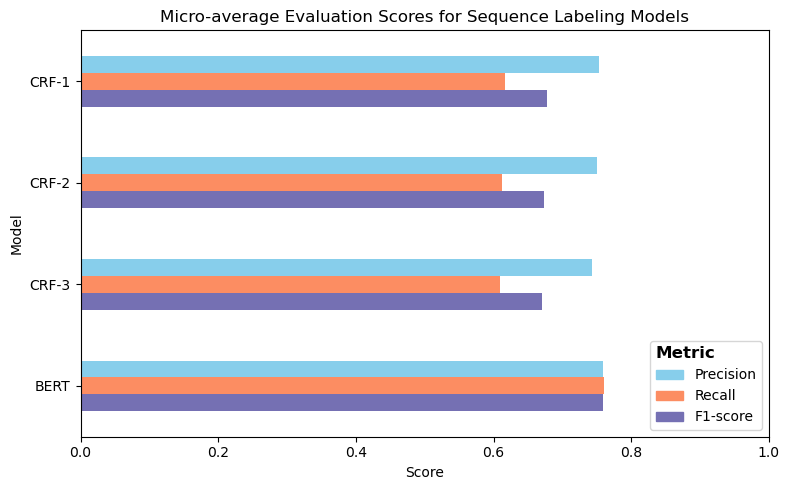


Detailed Entity-level Evaluation Results on the Test Set for All Models:



Model,Entity,Precision,Recall,F1-score,Support
CRF-1,LOC,0.71,0.41,0.52,636
CRF-1,ORG,0.60,0.28,0.38,1090
CRF-1,PER,0.79,0.81,0.80,2650
CRF-1,micro avg,0.75,0.62,0.68,4376
CRF-1,macro avg,0.70,0.50,0.56,4376
CRF-1,weighted avg,0.73,0.62,0.65,4376
CRF-2,LOC,0.70,0.40,0.51,636
CRF-2,ORG,0.60,0.28,0.38,1090
CRF-2,PER,0.79,0.80,0.79,2650
CRF-2,micro avg,0.75,0.61,0.67,4376



Heatmap below illustrates F1-scores of four sequence labeling models across entity types (LOC, ORG, PER) and aggregate metrics (macro, micro, weighted averages). Darker colors indicate better performance:



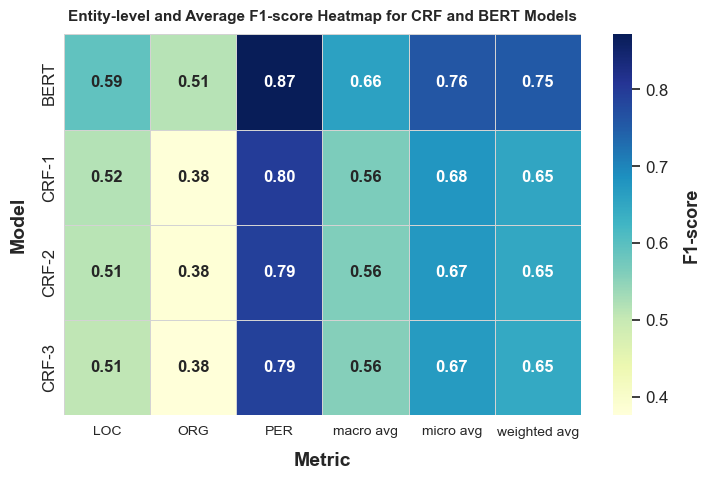

In [7]:
# Evaluate CRF models on the test set and return entity-level metrics in a structured format
def evaluate_crf_model(model_name, crf_model, X_test, y_test):
    y_pred = crf_model.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True, digits=4)

    rows = []
    for entity_name, scores in report_dict.items():
        if isinstance(scores, dict) and all(k in scores for k in ["precision","recall","f1-score","support"]):
            rows.append({
                "Model": model_name,
                "Entity": entity_name,
                "Precision": scores["precision"],
                "Recall":    scores["recall"],
                "F1-score":  scores["f1-score"],
                "Support":   scores["support"]
            })
    return rows

# Compute micro-averaged precision, recall, and F1-score for a CRF model
def get_crf_micro_metrics(crf_model, X_test, y_test):
    y_pred = crf_model.predict(X_test)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    return (prec, rec, f1)

# Generate token-level features and gold labels for the CRF test evaluation
X_test_basic = [sent2features_basic(s) for s in test_sents_basic]
y_test_basic = [sent2labels_basic(s) for s in test_sents_basic]

X_test_pos = [sent2features_pos(s) for s in test_sents_pos]
y_test_pos = [sent2labels_pos(s) for s in test_sents_pos]

X_test_tw = [sent2features_tw(s) for s in test_sents_tw]
y_test_tw = [sent2labels_tw(s) for s in test_sents_tw]

# Evaluate each CRF variant on the test set (micro metrics)
p1, r1, f1_1 = get_crf_micro_metrics(crf_basic, X_test_basic, y_test_basic)
p2, r2, f1_2 = get_crf_micro_metrics(crf_pos,   X_test_pos,   y_test_pos)
p3, r3, f1_3 = get_crf_micro_metrics(crf_tw,    X_test_tw,    y_test_tw)

# Compute entity-level classification metrics per CRF variant
results_crf1 = evaluate_crf_model("CRF-1", crf_basic, X_test_basic, y_test_basic)
results_crf2 = evaluate_crf_model("CRF-2", crf_pos,   X_test_pos,   y_test_pos)
results_crf3 = evaluate_crf_model("CRF-3", crf_tw,    X_test_tw,    y_test_tw)

# Combine all CRF entity-level metrics into a unified list
all_crf_rows = results_crf1 + results_crf2 + results_crf3

# Run prediction on the BERT model and extract logits and labels
test_results_bert = trainer_bert.predict(test_bert)
pred_logits_bert  = test_results_bert.predictions
pred_ids_bert     = np.argmax(pred_logits_bert, axis=-1)
true_label_ids_bert = test_results_bert.label_ids

# Extract word-level true and predicted labels, excluding subword positions (-100)
bert_pred_label_list = []
bert_true_label_list = []

for i in range(len(pred_ids_bert)):
    pred_i = pred_ids_bert[i]
    true_i = true_label_ids_bert[i]

    sample_pred = []
    sample_true = []
    for (p, t) in zip(pred_i, true_i):
        if t == -100:
            continue
        sample_pred.append(id2label_bert[p])
        sample_true.append(id2label_bert[t])
    bert_pred_label_list.append(sample_pred)
    bert_true_label_list.append(sample_true)

# Compute micro-averaged scores for the BERT model
bert_precision = precision_score(bert_true_label_list, bert_pred_label_list)
bert_recall    = recall_score(bert_true_label_list,    bert_pred_label_list)
bert_f1        = f1_score(bert_true_label_list,        bert_pred_label_list)
p4, r4, f4_bert = bert_precision, bert_recall, bert_f1

# Generate entity-level classification report for BERT
report_bert_test = classification_report(
    bert_true_label_list,
    bert_pred_label_list,
    output_dict=True,
    digits=4
)

# Convert BERT entity-level scores into a row-based summary format
rows_bert = []
for entity_name, scores in report_bert_test.items():
    if isinstance(scores, dict) and all(k in scores for k in ["precision","recall","f1-score","support"]):
        rows_bert.append({
            "Model": "BERT",
            "Entity": entity_name,
            "Precision": scores["precision"],
            "Recall":    scores["recall"],
            "F1-score":  scores["f1-score"],
            "Support":   scores["support"]
        })

# Combine CRF and BERT entity-level scores into a single table
all_entity_rows = all_crf_rows + rows_bert
df_entity_report = pd.DataFrame(all_entity_rows)

# Create a summary table comparing micro-averaged scores across all models
df_micro_summary = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "CRF-1":  [p1, r1, f1_1],
    "CRF-2":  [p2, r2, f1_2],
    "CRF-3":  [p3, r3, f1_3],
    "BERT":   [p4, r4, f4_bert],
})

# Define row border styling for the summary table
split_indices = [len(df_micro_summary) - 1]
def apply_borders(row):
    idx = row.name
    border_style = '1px solid black'
    return [f'border-bottom: {border_style}'] * len(row) if idx in split_indices else [''] * len(row)

# Format the summary table with styled borders and decimal formatting
styled_micro_summary = df_micro_summary.style \
    .format({col: "{:.2f}" for col in df_micro_summary.columns[1:]}) \
    .set_table_styles([
        {'selector': 'table', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid #999999'),
            ('border-left', '1px solid black'),
            ('border-right', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-left', '1px solid black'),
            ('border-right', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .apply(apply_borders, axis=1) \
    .hide(axis="index")

# Print summary table with explanation of each metric
print("The following table reflects micro-averaged evaluation metrics for each sequence labeling model:")
print(" - Precision: Proportion of predicted entities that are correct")
print(" - Recall: Proportion of true entities that are correctly predicted")
print(" - F1-score: Harmonic mean of precision and recall\n")
print("Model Performance Summary on Test Set (Micro-averaged Precision, Recall, F1-score):\n")

# Display the formatted summary table
display(styled_micro_summary)

# Reorder the summary table for plotting (F1 → Recall → Precision)
df_plot = df_micro_summary.set_index("Metric").T[["F1-score", "Recall", "Precision"]] 
df_plot = df_plot.iloc[::-1]

# Define color palette for metrics
colors = ["#7570b3", "#fc8d62", "#87ceeb"]

# Create horizontal bar plot comparing models by micro-averaged metrics
ax = df_plot.plot.barh(
    figsize=(8, 5),
    color=colors,
    title="Micro-average Evaluation Scores for Sequence Labeling Models",
    xlim=(0, 1)
)

# Add plot labels and legend
plt.xlabel("Score")
plt.ylabel("Model")

legend_handles = [
    Patch(color="#87ceeb", label="Precision"),
    Patch(color="#fc8d62", label="Recall"),
    Patch(color="#7570b3", label="F1-score")
]
legend = plt.legend(handles=legend_handles, title="Metric", loc="lower right")
legend._legend_box.align = "left"
legend.set_title("Metric", prop={"size": 12, "weight": "bold"})
legend.get_title().set_ha("left")

# Show the bar plot
plt.tight_layout()
print("\nHorizontal bar chart comparing four sequence labeling models based on micro-averaged evaluation scores: \n")
plt.show()

# Compute row indices for each model block in the entity-level evaluation table
model_groups = df_entity_report["Model"].value_counts().loc[["CRF-1", "CRF-2", "CRF-3", "BERT"]]
split_indices = np.cumsum(model_groups.values) - 1

# Define styling for separating model blocks in the entity-level table
def apply_entity_borders(row):
    idx = row.name
    border_style = '1px solid black'
    return [f'border-bottom: {border_style}'] * len(row) if idx in split_indices else [''] * len(row)

# Format and style the entity-level performance report
styled_entity_report = df_entity_report.style \
    .format({
        "Precision": "{:.2f}",
        "Recall": "{:.2f}",
        "F1-score": "{:.2f}",
        "Support": "{:.0f}"
    }) \
    .set_table_styles([
        {'selector': 'table', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid #999999'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .apply(apply_entity_borders, axis=1) \
    .hide(axis="index")

# Display entity-level F1, precision, recall, and support for each model
print("\nDetailed Entity-level Evaluation Results on the Test Set for All Models:\n")
display(styled_entity_report)

# Select key entities and averages to visualize in a heatmap
target_entities = ["LOC", "ORG", "PER", "micro avg", "macro avg", "weighted avg"]
heatmap_data = df_entity_report[df_entity_report["Entity"].isin(target_entities)]

# Pivot table to reshape entity-level F1-scores (rows: model, cols: entity)
heatmap_pivot = heatmap_data.pivot(index="Model", columns="Entity", values="F1-score")

# Create a heatmap showing per-entity F1-scores for each model
plt.figure(figsize=(9, 5))
sns.set(font_scale=1.1)
ax = sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": ""}, 
    linewidths=0.5,
    linecolor='lightgray',
    annot_kws={"size": 12, "weight": "bold"}
)

ax.set_title(
    "Entity-level and Average F1-score Heatmap for CRF and BERT Models",
    fontsize=11,
    weight='bold',
    pad=10
)
ax.set_xlabel("Metric", fontsize=14, weight='bold', labelpad=10)
ax.set_ylabel("Model", fontsize=14, weight='bold', labelpad=10)

ax.tick_params(axis='x', labelsize=10, pad=2)
ax.tick_params(axis='y', labelsize=12, pad=-1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

colorbar = ax.collections[0].colorbar
colorbar.set_label("F1-score", size=13, weight="bold", labelpad=10)

plt.tight_layout()
plt.subplots_adjust(right=0.8)

# Display the heatmap to file for report inclusion
print("\nHeatmap below illustrates F1-scores of four sequence labeling models across entity types (LOC, ORG, PER) and aggregate metrics (macro, micro, weighted averages). Darker colors indicate better performance:\n")
plt.show()

#### Step 2: Error Distribution Analysis Based on Label Transition Frequencies

In this step, we analyze the most frequent label transition errors made by the CRF and BERT models.

We extract the top-N transition errors for each model and consolidate them into a unified DataFrame for direct comparison. A grouped bar chart is used to visualize how each model contributes to specific types of entity confusions, such as misclassifying the beginning of an organization label (B-ORG) as the beginning of a person label (B-PER). This analysis enables a more fine-grained understanding of the systematic error patterns that arise during sequence labeling, offering insights beyond aggregate evaluation metrics.

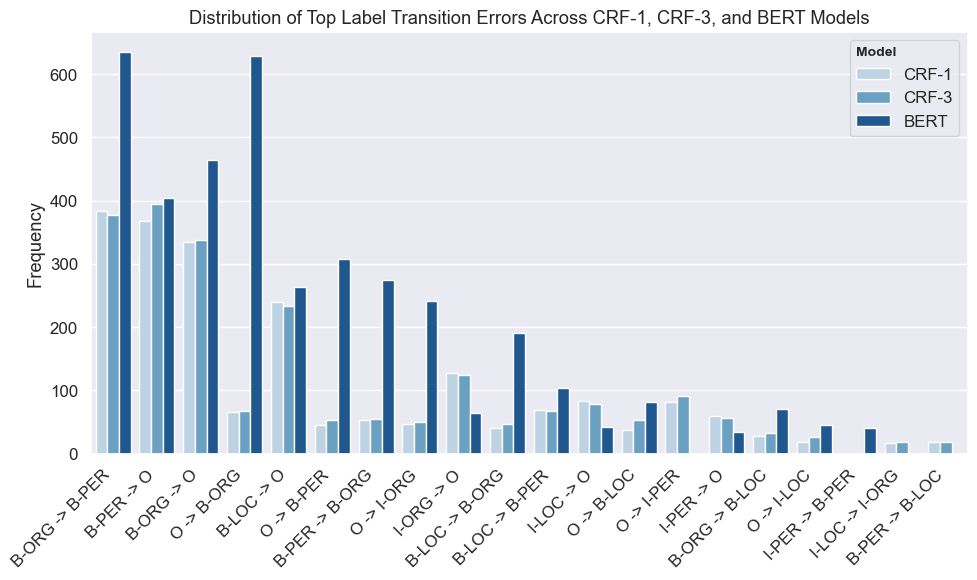

In [8]:
# Define a function to count label transition errors made by a sequence labeling model
def get_error_transitions(true_sequences, pred_sequences):

    # Compute a dictionary of (true_label -> predicted_label) counts, 
    # Remain tokens where the prediction is incorrect.
    counter = Counter()
    for true_seq, pred_seq in zip(true_sequences, pred_sequences):
        for t_label, p_label in zip(true_seq, pred_seq):
            if t_label != p_label:
                counter[(t_label, p_label)] += 1
    return counter

# Predict label sequences for CRF-1 and count its transition errors
y_pred_crf1 = crf_basic.predict(X_test_basic)
err_crf1 = get_error_transitions(y_test_basic, y_pred_crf1)

# Predict label sequences for CRF-3 and count its transition errors
y_pred_crf3 = crf_tw.predict(X_test_tw)
err_crf3 = get_error_transitions(y_test_tw, y_pred_crf3)

# Count BERT model's label transition errors (assumes true and predicted labels are aligned)
err_bert = get_error_transitions(bert_true_label_list, bert_pred_label_list)


# Merge the top-N most frequent label transition errors from trained models 
def merge_top_error_transitions(error_dicts, model_names, top_n=15):
    top_transition_sets = []
    for c in error_dicts:
        top_transition_sets.append(c.most_common(top_n))
    
    # Build a unified set of all error transitions
    all_transitions = set()
    for item_list in top_transition_sets:
        for (transition, _) in item_list:
            all_transitions.add(transition)
    
    # Initialize nested dictionary to hold transition counts for each model
    data_map = defaultdict(lambda: defaultdict(int))
    
    # Generate the data_map with frequency counts from each model
    for c, mname, item_list in zip(error_dicts, model_names, top_transition_sets):
        for (transition, count) in item_list:
            data_map[transition][mname] = count
    
    # Convert the merged results into a list of rows for DataFrame construction
    df_rows = []
    for transition in all_transitions:
        row_dict = {"transition": f"{transition[0]} -> {transition[1]}"}
        for mname in model_names:
            row_dict[mname] = data_map[transition][mname]
        df_rows.append(row_dict)
        
    df_merged = pd.DataFrame(df_rows)
    df_merged.set_index("transition", inplace=True)
    
    df_merged["sum_freq"] = df_merged[model_names].sum(axis=1)
    df_merged.sort_values("sum_freq", ascending=False, inplace=True)
    df_merged.drop(columns="sum_freq", inplace=True)
    df_merged = df_merged.head(top_n)
    
    return df_merged

# Plot a grouped bar chart showing the distribution of top label transition errors across models
def plot_grouped_error_transitions(df_error, model_names, title="Grouped Error Transitions"):
    df_plot = df_error.copy()
    
    # Initialize the figure
    plt.figure(figsize=(10, 6))

    # Select distinct shades of blue for the different models
    blues_cmap = colormaps["Blues"]
    custom_blues = [blues_cmap(i) for i in [0.3, 0.55, 0.85]]
    
    # Reshape the DataFrame into long-form for plotting with seaborn
    df_melted = df_plot.reset_index().melt(id_vars="transition", var_name="Model", value_name="Frequency")
    
    # Draw the grouped bar chart with transition types on the x-axis
    sns.barplot(
        data=df_melted,
        x="transition",
        y="Frequency",
        hue="Model",
        palette=custom_blues
    )
    
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("Frequency")

    # Format the legend to be bold and left-aligned
    legend = plt.legend(title="Model", loc="upper right")
    legend._legend_box.align = "left"
    legend.set_title("Model", prop={"weight": "bold", "size": 10})
    
    plt.tight_layout()
    plt.show()

# Define the list of model-specific error transition Counters to compare
model_err_dicts = [err_crf1, err_crf3, err_bert]
model_names     = ["CRF-1", "CRF-3", "BERT"]

# Merge the error transitions into a unified DataFrame
df_error_merged = merge_top_error_transitions(model_err_dicts, model_names, top_n=20)

# Visualize the merged transition errors using a grouped bar plot
plot_grouped_error_transitions(
    df_error_merged,
    model_names,
    title="Distribution of Top Label Transition Errors Across CRF-1, CRF-3, and BERT Models"
)

#### Step 3: Mismatch Detection Across Models

In this step, we extract concrete examples of test sentences where the predicted entity labels differ across models.
We focus on sentences that contain entities and exhibit disagreement between CRF models and BERT. The examples are structured in a DataFrame to compare true labels with predictions from each model.

In [9]:
# Define functions to generate predicted label sequences using each CRF model
def predict_labels_crf1(sent_dict):
    feats = sent2features_basic(sent_dict)
    return crf_basic.predict_single(feats)

def predict_labels_crf2(sent_dict):
    feats = sent2features_pos(sent_dict)
    return crf_pos.predict_single(feats)

def predict_labels_crf3(sent_dict):
    feats = sent2features_tw(sent_dict)
    return crf_tw.predict_single(feats)

# Define a function to retrieve gold-standard BIO labels from a sentence dictionary
def true_labels(sent_dict):
    return sent2labels_basic(sent_dict)

# Initialize mismatch case list and restrict to shorter test sentences for readability
test_len = len(test_sents_basic)
mismatch_cases = []
max_len = 20

# Loop over each sentence in the test set to collect examples with mismatched entity predictions
for idx in range(test_len):
    sent_dict = test_sents_basic[idx]
    tokens = sent_dict["tokens"]
    if len(tokens) > max_len:
        continue

    gold = true_labels(sent_dict)
    pred1 = predict_labels_crf1(sent_dict)
    pred2 = predict_labels_crf2(sent_dict)
    pred3 = predict_labels_crf3(sent_dict)

    # Check whether the sentence contains any labeled entity
    has_entity = any(lbl.startswith("B-") or lbl.startswith("I-") for lbl in gold if lbl != "O")

    # Identify mismatches between CRF predictions and gold entities
    mismatch_found = False
    for g, p1, p2, p3 in zip(gold, pred1, pred2, pred3):
        if g != "O" and (g != p1 or g != p2 or g != p3):
            mismatch_found = True
            break

    # Add sentence to the mismatch list if it contains entities and at least one error
    if has_entity and mismatch_found:
        mismatch_cases.append({
            "Index": idx,
            "Tokens": tokens,
            "True Labels": gold,
            "CRF-1 Prediction": pred1,
            "CRF-2 Prediction": pred2,
            "CRF-3 Prediction": pred3
        })

# Convert the list of mismatch examples to a DataFrame for analysis and display
df_mismatch = pd.DataFrame(mismatch_cases)

# Generate BERT model predictions aligned to word-level for each mismatch case
def bert_predictions_to_mismatch(df):
    bert_preds = []

    for row in df.itertuples():
        tokens = getattr(row, "Tokens")
        inputs = tokenizer_bert(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model_bert(**inputs)

        preds = outputs.logits.argmax(dim=-1).squeeze().tolist()
        word_ids = inputs.word_ids()
        predicted_tags = []
        previous_word_idx = None
        for idx_wp, word_idx in enumerate(word_ids):
            if word_idx is None or word_idx == previous_word_idx:
                continue
            predicted_tags.append(id2label_bert[preds[idx_wp]])
            previous_word_idx = word_idx

        bert_preds.append(predicted_tags)

    df = df.copy()
    df["BERT Prediction"] = bert_preds
    return df

# Apply the BERT prediction function to the mismatch DataFrame
df_mismatch = bert_predictions_to_mismatch(df_mismatch)
df_mismatch_show = df_mismatch.reset_index(drop=True)

split_indices = [len(df_mismatch_show) - 1]

def apply_borders_mismatch(row):
    idx = row.name
    border_style = '1px solid black'
    return [f'border-bottom: {border_style}'] * len(row) if idx in split_indices else [''] * len(row)

styled_mismatch = df_mismatch_show.style \
    .set_table_styles([
        {'selector': 'table', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid #999999'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .apply(apply_borders_mismatch, axis=1) \
    .hide(axis="index")

# Display formatted mismatch examples for human inspection and model error analysis
print("Mismatched entity predictions across CRF and BERT models:\n")
display(styled_mismatch)

Mismatched entity predictions across CRF and BERT models:



Index,Tokens,True Labels,CRF-1 Prediction,CRF-2 Prediction,CRF-3 Prediction,BERT Prediction
2,"['Enjoying', 'the', 'Chinese', 'Assoc', 'of', 'Vic', 'annual', 'dinner', 'right', 'here', 'in', 'Aston', '!', 'http://t.co/6geIkKyEiS']","['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']","['O', 'O', 'B-LOC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']","['O', 'O', 'O', 'I-ORG', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']"
5,"['Whatever', 'the', 'result', ',', 'a', 'great', 'effort', 'from', '@', 'GWS_Giants', 'tonight', '.', 'Fighting', 'hard', '.', '#aflhawksgiants']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'B-PER']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O']"
7,"['@', 'matt_levinson', '@', 'alisoncroggon', 'More', 'often', 'than', 'not', ',', 'that', 'loveliness', 'is', 'Leunig', '.']","['B-PER', 'B-PER', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O']","['B-PER', 'B-PER', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O']"
10,"['Only', '123', 'days', 'to', 'the', 'bounce', 'for', 'the', 'Cats', ""'"", 'first', 'game', 'of', 'the', '2011', 'season', '.', 'NS']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG']"
12,"['It', ""'s"", 'great', 'to', 'be', 'home', '-', 'nothing', 'like', 'being', 'welcomed', 'by', 'some', 'beautiful', '#darwin', 'Dry', 'Season', 'weather', '!']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']"
16,"['@', 'Trimega', 'any', 'more', 'would', 'have', 'been', 'unseemly', '.']","['B-ORG', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
21,"['just', 'finished', 'newsradio', 'with', 'marius', ',', 'about', 'to', 'talk', 'to', 'abc', 'news', 'breakfast', 'then', 'sky', 'am', 'agenda', '.']","['O', 'O', 'B-ORG', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'B-ORG', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

#### Step 4: Visual Comparison of Token-Level Predictions

In this step, we present a detailed, token-level side-by-side comparison of predictions from all models on selected sentences.
Each table displays the tokens along with their gold-standard and predicted labels from CRF-1, CRF-2, CRF-3, and BERT. The examples are chosen to highlight boundary issues, confusion between similar entity types, and challenges in social media-specific contexts.

In [10]:
# Define a function to display token-level predictions from all models on a selected sentence
def get_styled_all_models(index, split="test"):
    
    # Load the sentence from the appropriate dataset split (test or validation)
    if split == "test":
        sent_basic = test_sents_basic[index]
        sent_pos = test_sents_pos[index]
        sent_tw = test_sents_tw[index]
        sent_bert = test_sents_bert[index]
    elif split == "val":
        sent_basic = val_sents_basic[index]
        sent_pos = val_sents_pos[index]
        sent_tw = val_sents_tw[index]
        sent_bert = val_sents_bert[index]
    else:
        raise ValueError("split must be 'test' or 'val'.")

    # Extract the token list and true labels from the basic CRF input
    tokens = sent_basic["tokens"]
    true_labels_crf = sent2labels_basic(sent_basic)

    # Extract features and perform predictions using the three CRF models
    feats_crf1 = sent2features_basic(sent_basic)
    feats_crf2 = sent2features_pos(sent_pos)
    feats_crf3 = sent2features_tw(sent_tw)

    pred_crf1 = crf_basic.predict_single(feats_crf1)
    pred_crf2 = crf_pos.predict_single(feats_crf2)
    pred_crf3 = crf_tw.predict_single(feats_crf3)

    # Convert BERT label IDs to string labels for the current sentence
    gold_ids_bert = sent_bert["tags"]
    gold_labels_bert = [label_names_bert[i] for i in gold_ids_bert]

    # Tokenize the sentence and run it through the BERT model
    inputs = tokenizer_bert(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model_bert(**inputs)

    # Get predicted label IDs and align them to word-level tokens
    preds = outputs.logits.argmax(dim=-1).squeeze().tolist()
    word_ids = inputs.word_ids()
    pred_bert = []
    prev_word_idx = None
    for idx_wp, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == prev_word_idx:
            continue
        pred_bert.append(id2label_bert[preds[idx_wp]])
        prev_word_idx = word_idx

    # Construct rows where the true label is not "O" for focused entity evaluation
    rows = []
    for tok, gold, p1, p2, p3, p4 in zip(tokens, true_labels_crf, pred_crf1, pred_crf2, pred_crf3, pred_bert):
        if gold != "O":
            rows.append({
                "Token": tok,
                "True Label": gold,
                "CRF-1": p1,
                "CRF-2": p2,
                "CRF-3": p3,
                "BERT": p4
            })

    df = pd.DataFrame(rows)

    # Define row border styling for the last row of the table
    split_indices = [len(df) - 1]
    def apply_bottom_border(row):
        return ['border-bottom: 1px solid black'] * len(row) if row.name in split_indices else [''] * len(row)

    # Construct the styled table for visualization
    styled_df = df.style \
        .set_table_styles([
            {'selector': 'table', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]},
            {'selector': 'th', 'props': [
                ('text-align', 'left'),
                ('border-top', '1px solid black'),
                ('border-bottom', '1px solid #999999'),
                ('border-right', '1px solid black'),
                ('border-left', '1px solid black')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'left'),
                ('border-right', '1px solid black'),
                ('border-left', '1px solid black')
            ]}
        ]) \
        .set_properties(**{'text-align': 'left'}) \
        .apply(apply_bottom_border, axis=1) \
        .hide(axis="index")

    return styled_df

# Display example predictions for three selected sentences from the test set
print("\nExample 1 – Fine-grained evaluation of nested organizational entities within location-related mentions (ORG vs LOC):\n")
display(get_styled_all_models(2, split="test"))

print("\nExample 2 – Entity boundary recognition for social media handles and hashtags with implicit named entities:\n")
display(get_styled_all_models(5, split="test"))

print("\nExample 3 – Disambiguation between personal and organizational mentions in ambiguous user handles:\n")
display(get_styled_all_models(52, split="test"))


Example 1 – Fine-grained evaluation of nested organizational entities within location-related mentions (ORG vs LOC):



Token,True Label,CRF-1,CRF-2,CRF-3,BERT
Chinese,B-ORG,B-LOC,O,O,O
Assoc,I-ORG,O,O,O,I-ORG
of,I-ORG,O,O,O,O
Vic,I-ORG,B-LOC,B-LOC,B-LOC,B-LOC
Aston,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC



Example 2 – Entity boundary recognition for social media handles and hashtags with implicit named entities:



Token,True Label,CRF-1,CRF-2,CRF-3,BERT
@,B-ORG,B-ORG,O,O,B-ORG
GWS_Giants,B-ORG,B-ORG,O,O,B-ORG
#aflhawksgiants,B-PER,O,O,O,O



Example 3 – Disambiguation between personal and organizational mentions in ambiguous user handles:



Token,True Label,CRF-1,CRF-2,CRF-3,BERT
@,B-PER,B-PER,B-PER,B-PER,B-PER
Graeme_Bowman,B-PER,B-PER,B-PER,B-PER,B-PER
@,B-ORG,B-PER,B-PER,B-PER,B-PER
fightforthereef,B-ORG,B-PER,B-PER,B-PER,B-PER
